In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_BN_2(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_BN_2(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_15 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_16 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_39 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_40 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9297 - acc: 0.4066
Epoch 00001: val_loss improved from inf to 2.59448, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_3_conv_checkpoint/001-2.5945.hdf5
36805/36805 [==============================] - 161s 4ms/sample - loss: 2.9303 - acc: 0.4065 - val_loss: 2.5945 - val_acc: 0.4785
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3552 - acc: 0.6906
Epoch 00002: val_loss did not improve from 2.59448
36805/36805 [==============================] - 155s 4ms/sample - loss: 1.3555 - acc: 0.6905 - val_loss: 3.0606 - val_acc: 0.4568
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7318 - acc: 0.8254
Epoch 00003: val_loss did not improve from 2.59448
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.7320 - acc: 0.8253 - val_loss: 2.8504

36800/36805 [============================>.] - ETA: 0s - loss: 0.1228 - acc: 0.9805
Epoch 00029: val_loss did not improve from 2.59448
36805/36805 [==============================] - 157s 4ms/sample - loss: 0.1230 - acc: 0.9804 - val_loss: 4.9521 - val_acc: 0.5262
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1476 - acc: 0.9769
Epoch 00030: val_loss did not improve from 2.59448
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.1478 - acc: 0.9768 - val_loss: 4.8962 - val_acc: 0.5271
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1543 - acc: 0.9760
Epoch 00031: val_loss did not improve from 2.59448
36805/36805 [==============================] - 156s 4ms/sample - loss: 0.1549 - acc: 0.9760 - val_loss: 4.9504 - val_acc: 0.5348
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1278 - acc: 0.9802
Epoch 00032: val_loss did not improve from 2.59448
36805/36805 [=====================

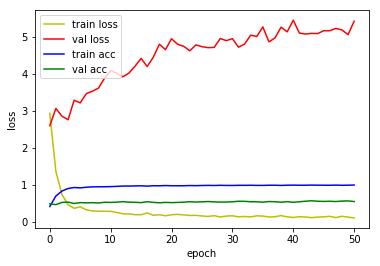

4815/4815 [==============================] - 9s 2ms/sample - loss: 2.7105 - acc: 0.4521
Loss: 2.7104660169110244 Accuracy: 0.45212877

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9659 - acc: 0.4773
Epoch 00001: val_loss improved from inf to 1.56177, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_4_conv_checkpoint/001-1.5618.hdf5
36805/36805 [==============================] - 166s 5ms/sample - loss: 1.9663 - acc: 0.4772 - val_loss: 1.5618 - val_acc: 0.5835
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0970 - acc: 0.6927
Epoch 00002: val_loss improved from 1.56177 to 1.55157, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_4_conv_checkpoint/002-1.5516.hdf5
36805/36805 [==============================] - 163s 4ms/sample - loss: 1.0972 - acc: 0.6926 - val_loss: 1.5516 - val_acc: 0.6033
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

36800/36805 [============================>.] - ETA: 0s - loss: 0.0647 - acc: 0.9833
Epoch 00028: val_loss did not improve from 1.42464
36805/36805 [==============================] - 162s 4ms/sample - loss: 0.0649 - acc: 0.9833 - val_loss: 2.6100 - val_acc: 0.6164
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9849
Epoch 00029: val_loss did not improve from 1.42464
36805/36805 [==============================] - 163s 4ms/sample - loss: 0.0583 - acc: 0.9849 - val_loss: 2.3074 - val_acc: 0.6485
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9902
Epoch 00030: val_loss did not improve from 1.42464
36805/36805 [==============================] - 161s 4ms/sample - loss: 0.0405 - acc: 0.9901 - val_loss: 2.3226 - val_acc: 0.6504
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9834
Epoch 00031: val_loss did not improve from 1.42464
36805/36805 [=====================

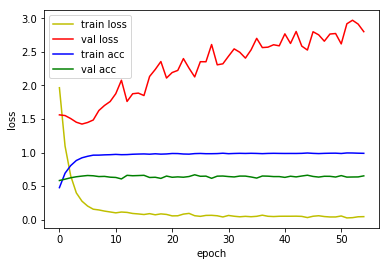

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.5670 - acc: 0.6183
Loss: 1.5669918747086886 Accuracy: 0.61827624

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7453 - acc: 0.5105
Epoch 00001: val_loss improved from inf to 1.43314, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_5_conv_checkpoint/001-1.4331.hdf5
36805/36805 [==============================] - 173s 5ms/sample - loss: 1.7454 - acc: 0.5105 - val_loss: 1.4331 - val_acc: 0.5977
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1183 - acc: 0.6835
Epoch 00002: val_loss improved from 1.43314 to 1.16184, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_5_conv_checkpoint/002-1.1618.hdf5
36805/36805 [==============================] - 168s 5ms/sample - loss: 1.1187 - acc: 0.6834 - val_loss: 1.1618 - val_acc: 0.6862
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9914
Epoch 00029: val_loss did not improve from 1.03979
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0378 - acc: 0.9913 - val_loss: 1.5625 - val_acc: 0.7237
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0893 - acc: 0.9753
Epoch 00030: val_loss did not improve from 1.03979
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0893 - acc: 0.9753 - val_loss: 1.4462 - val_acc: 0.7449
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9870
Epoch 00031: val_loss did not improve from 1.03979
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0485 - acc: 0.9870 - val_loss: 1.6380 - val_acc: 0.7193
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0611 - acc: 0.9840
Epoch 00032: val_loss did not improve from 1.03979
36805/36805 [========

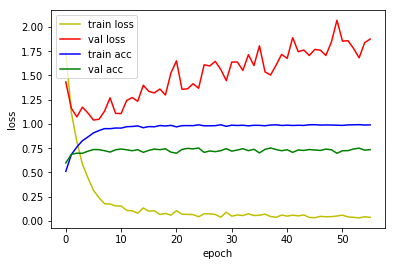

4815/4815 [==============================] - 10s 2ms/sample - loss: 1.1174 - acc: 0.7067
Loss: 1.11738782602431 Accuracy: 0.70674974

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5481 - acc: 0.5355
Epoch 00001: val_loss improved from inf to 1.21919, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_6_conv_checkpoint/001-1.2192.hdf5
36805/36805 [==============================] - 178s 5ms/sample - loss: 1.5481 - acc: 0.5355 - val_loss: 1.2192 - val_acc: 0.6348
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9825 - acc: 0.7077
Epoch 00002: val_loss improved from 1.21919 to 0.91854, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_6_conv_checkpoint/002-0.9185.hdf5
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.9825 - acc: 0.7076 - val_loss: 0.9185 - val_acc: 0.7342
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9742
Epoch 00027: val_loss did not improve from 0.52236
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0925 - acc: 0.9742 - val_loss: 0.5782 - val_acc: 0.8665
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0724 - acc: 0.9806
Epoch 00028: val_loss improved from 0.52236 to 0.51673, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_6_conv_checkpoint/028-0.5167.hdf5
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0724 - acc: 0.9806 - val_loss: 0.5167 - val_acc: 0.8791
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0532 - acc: 0.9869
Epoch 00029: val_loss did not improve from 0.51673
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.0536 - acc: 0.9868 - val_loss: 0.6401 - val_acc: 0.8651
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9868
Epoch 00056: val_loss did not improve from 0.51673
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.0465 - acc: 0.9867 - val_loss: 0.6081 - val_acc: 0.8800
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9912
Epoch 00057: val_loss did not improve from 0.51673
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0318 - acc: 0.9911 - val_loss: 0.8448 - val_acc: 0.8442
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9873
Epoch 00058: val_loss did not improve from 0.51673
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.0476 - acc: 0.9873 - val_loss: 0.6285 - val_acc: 0.8782
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9948
Epoch 00059: val_loss did not improve from 0.51673
36805/36805 [=====================

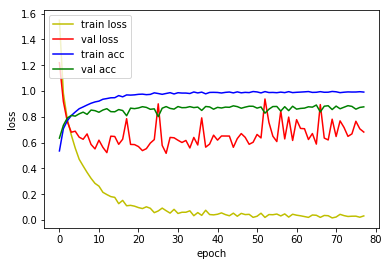

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.5803 - acc: 0.8588
Loss: 0.5803356407834981 Accuracy: 0.85877466

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4779 - acc: 0.5516
Epoch 00001: val_loss improved from inf to 0.97007, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_7_conv_checkpoint/001-0.9701.hdf5
36805/36805 [==============================] - 188s 5ms/sample - loss: 1.4780 - acc: 0.5516 - val_loss: 0.9701 - val_acc: 0.7102
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8027 - acc: 0.7684
Epoch 00002: val_loss improved from 0.97007 to 0.93215, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_7_conv_checkpoint/002-0.9322.hdf5
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.8028 - acc: 0.7683 - val_loss: 0.9322 - val_acc: 0.7412
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0607 - acc: 0.9828
Epoch 00026: val_loss did not improve from 0.22511
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0608 - acc: 0.9827 - val_loss: 0.2450 - val_acc: 0.9320
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0571 - acc: 0.9848
Epoch 00027: val_loss did not improve from 0.22511
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0572 - acc: 0.9848 - val_loss: 0.2578 - val_acc: 0.9324
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9844
Epoch 00028: val_loss did not improve from 0.22511
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0561 - acc: 0.9844 - val_loss: 0.2770 - val_acc: 0.9315
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9863
Epoch 00029: val_loss did not improve from 0.22511
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9963
Epoch 00055: val_loss did not improve from 0.21677
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0144 - acc: 0.9963 - val_loss: 0.2451 - val_acc: 0.9429
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9936
Epoch 00056: val_loss did not improve from 0.21677
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0234 - acc: 0.9936 - val_loss: 0.2430 - val_acc: 0.9418
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9942
Epoch 00057: val_loss did not improve from 0.21677
36805/36805 [==============================] - 179s 5ms/sample - loss: 0.0216 - acc: 0.9942 - val_loss: 0.2610 - val_acc: 0.9406
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9949
Epoch 00058: val_loss did not improve from 0.21677
36805/36805 [=====================


1D_CNN_custom_ch_128_BN_2_7_conv Model


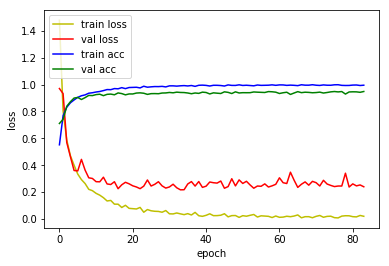

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.2638 - acc: 0.9236
Loss: 0.2638487214147116 Accuracy: 0.9235722

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2270 - acc: 0.6276
Epoch 00001: val_loss improved from inf to 0.68734, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_8_conv_checkpoint/001-0.6873.hdf5
36805/36805 [==============================] - 191s 5ms/sample - loss: 1.2270 - acc: 0.6276 - val_loss: 0.6873 - val_acc: 0.7948
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5252 - acc: 0.8472
Epoch 00002: val_loss improved from 0.68734 to 0.38946, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_8_conv_checkpoint/002-0.3895.hdf5
36805/36805 [==============================] - 185s 5ms/sample - loss: 0.5253 - acc: 0.8471 - val_loss: 0.3895 - val_acc: 0.8935
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - los

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9962
Epoch 00027: val_loss did not improve from 0.13191
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0181 - acc: 0.9961 - val_loss: 0.1461 - val_acc: 0.9562
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9899
Epoch 00028: val_loss did not improve from 0.13191
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0353 - acc: 0.9899 - val_loss: 0.1543 - val_acc: 0.9604
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0181 - acc: 0.9964
Epoch 00029: val_loss did not improve from 0.13191
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0184 - acc: 0.9964 - val_loss: 0.1970 - val_acc: 0.9515
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9898
Epoch 00030: val_loss did not improve from 0.13191
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9974
Epoch 00056: val_loss did not improve from 0.13171
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0113 - acc: 0.9974 - val_loss: 0.1472 - val_acc: 0.9646
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0057 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.13171
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.0060 - acc: 0.9989 - val_loss: 0.1640 - val_acc: 0.9599
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0211 - acc: 0.9939
Epoch 00058: val_loss did not improve from 0.13171
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0211 - acc: 0.9939 - val_loss: 0.1536 - val_acc: 0.9611
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9960
Epoch 00059: val_loss did not improve from 0.13171
36805/36805 [=====================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0035 - acc: 0.9994
Epoch 00086: val_loss did not improve from 0.13171
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0038 - acc: 0.9993 - val_loss: 0.1431 - val_acc: 0.9653
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.13171
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0092 - acc: 0.9977 - val_loss: 0.1401 - val_acc: 0.9662
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9994
Epoch 00088: val_loss did not improve from 0.13171
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0033 - acc: 0.9994 - val_loss: 0.1394 - val_acc: 0.9695
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9992
Epoch 00089: val_loss did not improve from 0.13171
36805/36805 [========

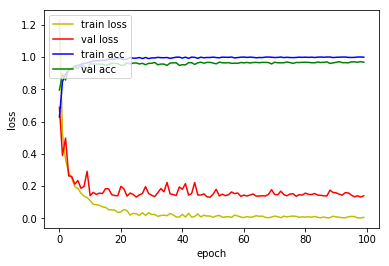

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1793 - acc: 0.9562
Loss: 0.17933893078398483 Accuracy: 0.9561786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8557 - acc: 0.7330
Epoch 00001: val_loss improved from inf to 0.39877, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_9_conv_checkpoint/001-0.3988.hdf5
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.8557 - acc: 0.7331 - val_loss: 0.3988 - val_acc: 0.8796
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3299 - acc: 0.8982
Epoch 00002: val_loss improved from 0.39877 to 0.27207, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_9_conv_checkpoint/002-0.2721.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.3302 - acc: 0.8981 - val_loss: 0.2721 - val_acc: 0.9175
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - lo

36800/36805 [============================>.] - ETA: 0s - loss: 0.0167 - acc: 0.9959
Epoch 00026: val_loss did not improve from 0.13452
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0167 - acc: 0.9959 - val_loss: 0.1418 - val_acc: 0.9658
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0159 - acc: 0.9957
Epoch 00027: val_loss did not improve from 0.13452
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0163 - acc: 0.9956 - val_loss: 0.1819 - val_acc: 0.9469
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9906
Epoch 00028: val_loss did not improve from 0.13452
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0298 - acc: 0.9906 - val_loss: 0.1368 - val_acc: 0.9667
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0152 - acc: 0.9961
Epoch 00029: val_loss did not improve from 0.13452
36805/36805 [=====================

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9993
Epoch 00055: val_loss did not improve from 0.11907
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0033 - acc: 0.9993 - val_loss: 0.1425 - val_acc: 0.9667
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9942
Epoch 00056: val_loss did not improve from 0.11907
36805/36805 [==============================] - 183s 5ms/sample - loss: 0.0189 - acc: 0.9942 - val_loss: 0.1329 - val_acc: 0.9658
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9984
Epoch 00057: val_loss improved from 0.11907 to 0.11863, saving model to model/checkpoint/1D_CNN_custom_ch_128_BN_2_9_conv_checkpoint/057-0.1186.hdf5
36805/36805 [==============================] - 180s 5ms/sample - loss: 0.0063 - acc: 0.9984 - val_loss: 0.1186 - val_acc: 0.9686
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0083 - acc: 0.9975
Epoch 00084: val_loss did not improve from 0.11792
36805/36805 [==============================] - 184s 5ms/sample - loss: 0.0083 - acc: 0.9975 - val_loss: 0.1679 - val_acc: 0.9634
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9991
Epoch 00085: val_loss did not improve from 0.11792
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0032 - acc: 0.9991 - val_loss: 0.1365 - val_acc: 0.9693
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9986
Epoch 00086: val_loss did not improve from 0.11792
36805/36805 [==============================] - 181s 5ms/sample - loss: 0.0051 - acc: 0.9985 - val_loss: 0.1507 - val_acc: 0.9653
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0130 - acc: 0.9961
Epoch 00087: val_loss did not improve from 0.11792
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9976
Epoch 00113: val_loss did not improve from 0.11365
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0078 - acc: 0.9976 - val_loss: 0.1377 - val_acc: 0.9693
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9984
Epoch 00114: val_loss did not improve from 0.11365
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0060 - acc: 0.9984 - val_loss: 0.1320 - val_acc: 0.9700
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9993
Epoch 00115: val_loss did not improve from 0.11365
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.0025 - acc: 0.9993 - val_loss: 0.1231 - val_acc: 0.9730
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0018 - acc: 0.9996
Epoch 00116: val_loss did not improve from 0.11365
36805/36805 [==================

Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9988
Epoch 00143: val_loss did not improve from 0.11365
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0037 - acc: 0.9988 - val_loss: 0.1408 - val_acc: 0.9706
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9986
Epoch 00144: val_loss did not improve from 0.11365
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0052 - acc: 0.9985 - val_loss: 0.1498 - val_acc: 0.9679
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9981
Epoch 00145: val_loss did not improve from 0.11365
36805/36805 [==============================] - 172s 5ms/sample - loss: 0.0059 - acc: 0.9981 - val_loss: 0.1634 - val_acc: 0.9693
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9985
Epoch 00146: val_loss did not improve from 0.11365
36805/36805 [====

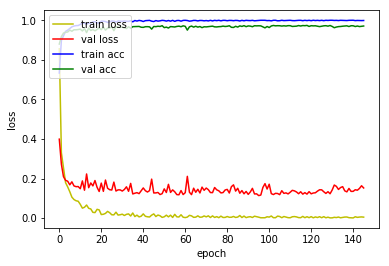

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.1672 - acc: 0.9632
Loss: 0.16719291592945237 Accuracy: 0.96323985



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_BN_2'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_BN_2(conv_num=i)
        
    model = multi_gpu_model(model, gpus=2)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [12]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_BN_2'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_BN_2_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           4715536     lambda[0][0]                     
                                                                 lamb

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2638 - acc: 0.9236
Loss: 0.2638487214147116 Accuracy: 0.9235722

1D_CNN_custom_ch_128_BN_2_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (N

In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_BN_2_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 16)           4715536     lambda[0][0]                     
                                                                 lamb

4815/4815 [==============================] - 12s 3ms/sample - loss: 0.2763 - acc: 0.9356
Loss: 0.2763214694624254 Accuracy: 0.93561786

1D_CNN_custom_ch_128_BN_2_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_67_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 16000, 1)     0           conv1d_67_input[0][0]            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (